In [111]:
#connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks

In [45]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\madal\Desktop\MSc-Data-Science\Thesis


In [46]:
#import the packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, precision_recall_curve, auc
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold

In [47]:
#set random seed
np.random.seed(42)

In [48]:
#load dataset from csv file, and -1 is NA
df = pd.read_csv('Base.csv')

In [49]:
#drop velocity 6h, 4w 
columns_to_drop = ['velocity_6h', 'velocity_4w']
df = df.drop(columns=columns_to_drop)

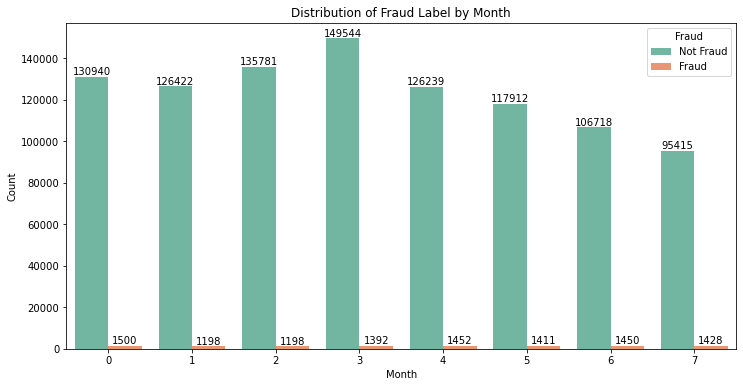

In [117]:
plt.figure(figsize=(12, 6))

# Create the countplot
ax = sns.countplot(data=df, x='month', hue='fraud_bool', palette='Set2')

# Annotate the count of instances for each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Fraud Label by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

In [118]:
#1 full data, basic split

In [32]:

X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

In [33]:
#a new column combining 'month' and 'y' values for stratified splitting
df['month_y'] = df['month'].astype(str) + '_' + df['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(df, df['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
df.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [35]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(), categorical_cols),
        ('cat_valid', OneHotEncoder(), categorical_cols),
        ('cat_test', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [39]:
##save to file 

#convert the transformed arrays/matrices back to pandas df
#X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
#X_train_transformed_df.to_csv('X_train_transformed_basicfull.csv', index=False)
X_valid_transformed_df.to_csv('X_valid_transformed_basicfull.csv', index=False)
X_test_transformed_df.to_csv('X_test_transformed_basicfull.csv', index=False)


#y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_valid)
y_test_df = pd.DataFrame(y_test)

#y_train_df.to_csv('y_train_basicfull.csv', index=False)
y_valid_df.to_csv('y_valid_basicfull.csv', index=False)
y_test_df.to_csv('y_test_basicfull.csv', index=False)

In [43]:
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_train_transformed_df.to_csv('X_train_transformed_basicfull.csv', index=False)
y_train_df = pd.DataFrame(y_train)
y_train_df.to_csv('y_train_basicfull.csv', index=False)

In [41]:
#3 SMOTE, full data
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can adjust the sampling strategy as needed

X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

#save to file
X_train_smote_df = pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_train_smote_df.to_csv('X_train_transformed_smote.csv', index=False)
y_train_smote_df.to_csv('y_train_smote.csv', index=False)

In [42]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_smote)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")


Number of features is the same in training and validation sets.


In [13]:
diff_columns_valid_train = set(X_valid_transformed_df.columns) - set(X_train_smote_df.columns)
diff_columns_train_valid = set(X_train_smote_df.columns) - set(X_valid_transformed_df.columns)

print("Columns present in X_valid but not in X_test:", diff_columns_valid_train)
print("Columns present in X_test but not in X_valid:", diff_columns_train_valid)

Columns present in X_valid but not in X_test: set()
Columns present in X_test but not in X_valid: set()


In [44]:
#5 ADASYN, full data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

X_train_oversampled, y_train_oversampled = adasyn.fit_resample(X_train_transformed, y_train)

#save to file
X_train_oversampled_df = pd.DataFrame(X_train_oversampled)
y_train_oversampled_df = pd.DataFrame(y_train_oversampled)
X_train_oversampled_df.to_csv('X_train_transformed_adasyn.csv', index=False)
y_train_oversampled_df.to_csv('y_train_adasyn.csv', index=False)

In [36]:
#7 random undersampling, full data

#set the sampling strategy to achieve a balanced class distribution
sampling_strategy = 'auto'  #or a specific ratio like 0.5 for 50-50 balance

#create RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

#apply the undersampling to the data
X_resampled, y_resampled = undersampler.fit_resample(X_train_transformed, y_train)

#print the distribution of classes after undersampling
print("Class distribution after undersampling:", Counter(y_resampled))

Class distribution after undersampling: Counter({0: 7147, 1: 7147})


In [38]:
##save to file
X_resampled_df = pd.DataFrame(X_resampled)
y_resampled_df = pd.DataFrame(y_resampled)
X_resampled_df.to_csv('X_train_random_undersampl.csv', index=False)
y_resampled_df.to_csv('y_train_random_undersampl.csv', index=False)

In [40]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")


Number of features is the same in training and validation sets.


In [41]:
#8 stratified undersampling, full data
#based on https://neurostars.org/t/stratification-using-imbalanced-learn/4523/3

In [7]:
class StratifiedRandomUnderSampler():
    
    def __init__(self, df, X_columns, y_name, groupvar_name, sampling_strategy='auto',
                 random_state=None, replacement=False):
        
        self.df = df
        self.X_columns = X_columns
        self.y_name = y_name
        self.groupvar_name = groupvar_name
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.replacement = replacement
        
    def resample(self):
        self.df_res_ = self.df.groupby(self.groupvar_name).apply(self._random_undersample,
                                  X_columns=self.X_columns,
                                  y_name=self.y_name
                                  )
        
        self.df_res_.set_index(self.df_res_.index.get_level_values(1), inplace=True)
        
        self.X_ = self.df_res_[self.X_columns]
        self.y_ = self.df_res_[self.y_name]
        
        return self.X_, self.y_, self.df_res_
        
    def _random_undersample(self, group_df, X_columns, y_name):
        if group_df[y_name].nunique() > 1:
            X = group_df[X_columns].values
            rus = RandomUnderSampler(sampling_strategy=self.sampling_strategy,
                                     random_state=self.random_state,
                                     replacement=self.replacement)
    
            X_resampled, y_resampled = rus.fit_resample(X, group_df[y_name])
            
            indices = rus.sample_indices_
            
            return group_df.iloc[indices]

In [21]:
pd.set_option('display.max_columns', None)
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_24h,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,3134.319630,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,2670.918292,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,2893.621498,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,4054.908412,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,2728.237159,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,8341.468557,1,8,CA,75,1,BC,1,1,25,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,4955.170808,0,2,CC,154,1,BC,1,1,-1,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,5670.654316,2023,6,CF,64,0,BC,0,1,11,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,3982.582204,1678,6,CA,163,0,BA,1,0,28,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


In [8]:
#list of columns to feed the Stratified Random Resampler
X_columns = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 
             'days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_24h', 'bank_branch_count_8w', 
             'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 
             'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 
             'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 
             'device_fraud_count']
y_name = 'fraud_bool'
groupvar_name = 'month'


sampler = StratifiedRandomUnderSampler(df, X_columns, y_name, groupvar_name, sampling_strategy='auto', random_state=42)

X_resampled, y_resampled, df_resampled = sampler.resample()

#show original and resampled data
print("Original Data:")
print(df)
print("\nResampled Data:")
print(df_resampled)

Original Data:
        fraud_bool  income  name_email_similarity  prev_address_months_count  \
0                1     0.9               0.166828                         -1   
1                1     0.9               0.296286                         -1   
2                1     0.9               0.044985                         -1   
3                1     0.9               0.159511                         -1   
4                1     0.9               0.596414                         -1   
...            ...     ...                    ...                        ...   
999995           0     0.6               0.192631                         -1   
999996           0     0.8               0.322989                        148   
999997           0     0.8               0.879403                         -1   
999998           0     0.9               0.762112                         -1   
999999           0     0.2               0.697452                         -1   

        current_address_

In [22]:
df_resampled

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_24h,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
740614,0,0.9,0.536068,-1,161,50,0.003879,34.686035,AA,3448,7513.209900,1,5,CA,37,0,BB,0,1,10,1,990.0,0,INTERNET,9.744385,other,1,1,0,0
752775,0,0.9,0.322860,-1,52,20,10.462791,-1.532356,AB,1657,5882.602285,1379,17,CA,34,0,BE,1,0,28,0,200.0,0,INTERNET,4.513985,windows,1,1,0,0
750062,0,0.5,0.420191,78,15,30,0.032406,-0.999816,AC,1299,6545.561246,0,8,CA,166,1,BB,1,0,-1,1,510.0,0,INTERNET,4.175288,other,0,1,0,0
684181,0,0.7,0.450660,28,8,40,0.007378,50.427017,AA,777,6255.503445,1,3,CA,153,1,BC,0,1,15,1,1500.0,0,INTERNET,7.472139,linux,0,1,0,0
641948,0,0.5,0.760305,-1,183,20,0.003970,-1.066543,AD,4789,7263.027739,10,23,CA,170,0,BE,1,1,5,0,1500.0,0,INTERNET,26.373656,linux,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,1,0.9,0.602496,-1,115,30,0.004755,-0.963996,AD,1730,4492.786033,7,7,CA,229,1,BC,0,1,15,0,200.0,0,INTERNET,5.750634,macintosh,0,1,0,7
1424,1,0.9,0.184026,-1,30,30,0.006009,-0.583967,AC,368,2757.023487,0,1,CA,292,1,BA,0,1,-1,0,990.0,0,INTERNET,34.915231,windows,0,1,0,7
1425,1,0.9,0.285290,-1,141,50,0.010505,-0.966960,AD,1092,3043.162933,15,2,CA,309,1,BB,0,1,1,0,1500.0,0,INTERNET,3.938780,windows,1,1,0,7
1426,1,0.4,0.718924,-1,153,20,3.517146,-0.358111,AC,104,2048.683562,0,5,CA,174,1,BA,0,1,-1,0,1000.0,0,INTERNET,6.130129,windows,1,1,0,7


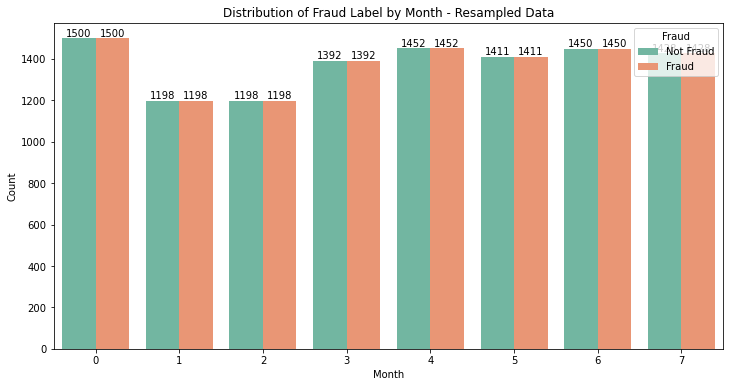

In [44]:
##check distribution in df_resampled
plt.figure(figsize=(12, 6))

# Create the countplot
ax = sns.countplot(data=df_resampled, x='month', hue='fraud_bool', palette='Set2')

# Annotate the count of instances for each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Fraud Label by Month - Resampled Data')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

In [23]:
X = df_resampled.drop('fraud_bool', axis=1)
y = df_resampled['fraud_bool']

In [24]:
##from df_resampled perform the train/valid/test split; one-hot encode and scale

 #a new column combining 'month' and 'y' values for stratified splitting
df_resampled['month_y'] = df_resampled['month'].astype(str) + '_' + df_resampled['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(df_resampled, df_resampled['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
df_resampled.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [26]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(), categorical_cols),
        ('cat_valid', OneHotEncoder(), categorical_cols),
        ('cat_test', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_undersampled_str = pipeline.fit_transform(X_train)
X_valid_undersampled_str = pipeline.transform(X_valid)
X_test_undersampled_str = pipeline.transform(X_test)

In [29]:
#convert the transformed arrays/matrices back to pandas df
X_train_undersampled_df = pd.DataFrame(X_train_undersampled_str)
#X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
#X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
X_train_undersampled_df.to_csv('X_train_undersampled_str.csv', index=False)
#X_valid_transformed_df.to_csv('X_valid_transformed_basicfull.csv', index=False)
#X_test_transformed_df.to_csv('X_test_transformed_basicfull.csv', index=False)


y_train_df = pd.DataFrame(y_train)
#y_valid_df = pd.DataFrame(y_valid)
#y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('y_train_undersampled_str.csv', index=False)
#y_valid_df.to_csv('y_valid_basicfull.csv', index=False)
#y_test_df.to_csv('y_test_basicfull.csv', index=False)

In [28]:

#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled_str)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")



Number of features is the same in training and validation sets.


In [111]:
df = pd.read_csv('Base.csv')

#drop velocity 6h, 4w 
columns_to_drop = ['velocity_6h', 'velocity_4w']
df = df.drop(columns=columns_to_drop)

In [112]:
##drop person-specific columns
columns_to_drop = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'employment_status', 'credit_risk_score'] 

df_trans = df.drop(columns=columns_to_drop)

In [113]:
X = df_trans.drop('fraud_bool', axis=1)
y = df_trans['fraud_bool']

In [114]:
#9 full transactional, basic split 
#a new column combining 'month' and 'y' values for stratified splitting
df_trans['month_y'] = df_trans['month'].astype(str) + '_' + df_trans['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(df_trans, df_trans['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
df_trans.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [116]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(), categorical_cols),
        ('cat_valid', OneHotEncoder(), categorical_cols),
        ('cat_test', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [117]:
##save to file 

#convert the transformed arrays/matrices back to pandas df
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
X_train_transformed_df.to_csv('X_train_transformed_basic_trans.csv', index=False)
X_valid_transformed_df.to_csv('X_valid_transformed_basic_trans.csv', index=False)
X_test_transformed_df.to_csv('X_test_transformed_basic_trans.csv', index=False)


y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_valid)
y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('y_train_basic_trans.csv', index=False)
y_valid_df.to_csv('y_valid_basic_trans.csv', index=False)
y_test_df.to_csv('y_test_basic_trans.csv', index=False)

In [57]:
#11 SMOTE, full transactional   
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can adjust the sampling strategy as needed

X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

#save to file
X_train_smote_df = pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_train_smote_df.to_csv('X_train_transformed_smote_trans.csv', index=False)
y_train_smote_df.to_csv('y_train_smote_trans.csv', index=False)

In [58]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_smote)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [59]:
#13 ADASYN, full transactional 

adasyn = ADASYN(sampling_strategy='auto', random_state=42)

X_train_oversampled, y_train_oversampled = adasyn.fit_resample(X_train_transformed, y_train)

#save to file
X_train_oversampled_df = pd.DataFrame(X_train_oversampled)
y_train_oversampled_df = pd.DataFrame(y_train_oversampled)
X_train_oversampled_df.to_csv('X_train_transformed_adasyn_trans.csv', index=False)
y_train_oversampled_df.to_csv('y_train_adasyn_trans.csv', index=False)

In [60]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_oversampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [61]:
#15 random undersampling, full transactional
#set the sampling strategy to achieve a balanced class distribution
sampling_strategy = 'auto'  #or a specific ratio like 0.5 for 50-50 balance

#create RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

#apply the undersampling to the data
X_resampled, y_resampled = undersampler.fit_resample(X_train_transformed, y_train)

#print the distribution of classes after undersampling
print("Class distribution after undersampling:", Counter(y_resampled))

Class distribution after undersampling: Counter({0: 7147, 1: 7147})


In [62]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_resampled)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [63]:
##save to file
X_resampled_df = pd.DataFrame(X_resampled)
y_resampled_df = pd.DataFrame(y_resampled)
X_resampled_df.to_csv('X_train_random_undersampl_trans.csv', index=False)
y_resampled_df.to_csv('y_train_random_undersampl_trans.csv', index=False)

In [118]:
#16 stratified undersampling, full transactional data

#list of columns to feed the Stratified Random Resampler
#exclude ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'employment_status', 'credit_risk_score'] 
X_columns = ['days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_24h', 'bank_branch_count_8w', 
             'date_of_birth_distinct_emails_4w', 'email_is_free', 'housing_status', 
             'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 
             'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 
             'device_fraud_count']
y_name = 'fraud_bool'
groupvar_name = 'month'


sampler = StratifiedRandomUnderSampler(df_trans, X_columns, y_name, groupvar_name, sampling_strategy='auto', random_state=42)

X_resampled, y_resampled, df_resampled = sampler.resample()

#show original and resampled data
print("Original Data:")
print(df_trans)
print("\nResampled Data:")
print(df_resampled)


Original Data:
        fraud_bool  days_since_request  intended_balcon_amount payment_type  \
0                1            0.020925               -1.331345           AA   
1                1            0.005418               -0.816224           AB   
2                1            3.108549               -0.755728           AC   
3                1            0.019079               -1.205124           AB   
4                1            0.004441               -0.773276           AB   
...            ...                 ...                     ...          ...   
999995           0            0.030592               -1.044454           AB   
999996           0            1.628119               -1.409803           AC   
999997           0            0.018563               34.692760           AA   
999998           0            0.015352               94.661055           AA   
999999           0            2.655916                9.908499           AA   

        zip_count_4w  velocity_24h  

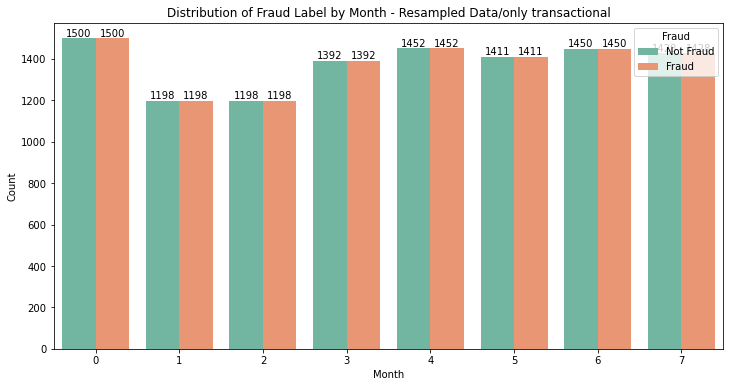

In [119]:
plt.figure(figsize=(12, 6))

# Create the countplot
ax = sns.countplot(data=df_resampled, x='month', hue='fraud_bool', palette='Set2')

# Annotate the count of instances for each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Fraud Label by Month - Resampled Data/only transactional')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

In [120]:
X = df_resampled.drop('fraud_bool', axis=1)
y = df_resampled['fraud_bool']

In [121]:
##from df_resampled perform the train/valid/test split; one-hot encode and scale

 #a new column combining 'month' and 'y' values for stratified splitting
df_resampled['month_y'] = df_resampled['month'].astype(str) + '_' + df_resampled['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(df_resampled, df_resampled['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
df_resampled.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [123]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(), categorical_cols),
        ('cat_valid', OneHotEncoder(), categorical_cols),
        ('cat_test', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_undersampled_str = pipeline.fit_transform(X_train)
X_valid_undersampled_str = pipeline.transform(X_valid)
X_test_undersampled_str = pipeline.transform(X_test)

In [124]:
#convert arrays to pandas df
X_train_df = pd.DataFrame(X_train_undersampled_str)
X_valid_df = pd.DataFrame(X_valid_transformed)

#get the columns/features of each dataset
features_train = set(X_train_df.columns)
features_valid = set(X_valid_df.columns)

#check if the features are the same
if features_train == features_valid:
    print("Number of features is the same in training and validation sets.")
else:
    print("Number of features is different in training and validation sets.")

Number of features is the same in training and validation sets.


In [56]:
#convert the transformed arrays/matrices back to pandas df
X_train_undersampled_df = pd.DataFrame(X_train_undersampled_str)
#X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
#X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
X_train_undersampled_df.to_csv('X_train_undersampled_str_trans.csv', index=False)
#X_valid_transformed_df.to_csv('X_valid_transformed_basicfull.csv', index=False)
#X_test_transformed_df.to_csv('X_test_transformed_basicfull.csv', index=False)


y_train_df = pd.DataFrame(y_train)
#y_valid_df = pd.DataFrame(y_valid)
#y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('y_train_undersampled_str_trans.csv', index=False)
#y_valid_df.to_csv('y_valid_basicfull.csv', index=False)
#y_test_df.to_csv('y_test_basicfull.csv', index=False)


In [138]:

#2 10% data, basic split
num_samples = len(df)

#calculate the number of samples to select (10%)
num_samples_to_select = int(0.10 * num_samples)

#check if the number of samples to select exceeds the number of rows
if num_samples_to_select > num_samples:
    num_samples_to_select = num_samples

#randomly select the specified number of samples
selected_df = df.sample(n=num_samples_to_select, random_state=42)

#a new column combining 'month' and 'y' values for stratified splitting
selected_df['month_y'] = selected_df['month'].astype(str) + '_' + selected_df['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(selected_df, selected_df['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
selected_df.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [140]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(), categorical_cols),
        ('cat_valid', OneHotEncoder(), categorical_cols),
        ('cat_test', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [141]:
##save to file 

#convert the transformed arrays/matrices back to pandas df
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
X_train_transformed_df.to_csv('10_X_train_transformed_basic.csv', index=False)
X_valid_transformed_df.to_csv('10_X_valid_transformed_basic.csv', index=False)
X_test_transformed_df.to_csv('10_X_test_transformed_basic.csv', index=False)


y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_valid)
y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('10_y_train_basic.csv', index=False)
y_valid_df.to_csv('10_y_valid_basic.csv', index=False)
y_test_df.to_csv('10_y_test_basic.csv', index=False)

In [142]:
#4 SMOTE, 10% full
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can adjust the sampling strategy as needed

X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

#save to file
X_train_smote_df = pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_train_smote_df.to_csv('10_X_train_transformed_smote.csv', index=False)
y_train_smote_df.to_csv('10_y_train_smote.csv', index=False)


In [143]:
#6 ADASYN, 10%
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

X_train_oversampled, y_train_oversampled = adasyn.fit_resample(X_train_transformed, y_train)

#save to file
X_train_oversampled_df = pd.DataFrame(X_train_oversampled)
y_train_oversampled_df = pd.DataFrame(y_train_oversampled)
X_train_oversampled_df.to_csv('10_X_train_transformed_adasyn.csv', index=False)
y_train_oversampled_df.to_csv('10_y_train_adasyn.csv', index=False)

In [144]:
##drop person-specific columns
columns_to_drop = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'employment_status', 'credit_risk_score'] 

df__selected_trans = selected_df.drop(columns=columns_to_drop)

In [145]:
#10 basic split, 10% transactional

num_samples = len(df__selected_trans)

#calculate the number of samples to select (10%)
num_samples_to_select = int(0.10 * num_samples)

#check if the number of samples to select exceeds the number of rows
if num_samples_to_select > num_samples:
    num_samples_to_select = num_samples

#randomly select the specified number of samples
df__selected_trans = df.sample(n=num_samples_to_select, random_state=42)

#a new column combining 'month' and 'y' values for stratified splitting
df__selected_trans['month_y'] = df__selected_trans['month'].astype(str) + '_' + df__selected_trans['fraud_bool'].astype(str)

#StratifiedShuffleSplit with 8 splits
sss = StratifiedShuffleSplit(n_splits=8, test_size=0.2, random_state=42)

#a list to store the indices of train and test data for each split
split_indices = []

for train_index, test_index in sss.split(df__selected_trans, df__selected_trans['month_y']):
    split_indices.append((train_index, test_index))

#drop the temporary 'month_y' column
df__selected_trans.drop(columns=['month_y'], inplace=True)

#8 sets of train and test sets in 'split_indices' based on 'month' and 'y'
#use these indices to create train and test sets for 8 splits
for i, (train_index, test_index) in enumerate(split_indices):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]


In [146]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [147]:
##scale and one-hot encode 
categorical_cols = ['payment_type', 'housing_status', 'source', 'device_os']

#create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_train', StandardScaler(with_mean=False), X_train.select_dtypes(exclude=['object']).columns),
        ('num_valid', StandardScaler(with_mean=False), X_valid.select_dtypes(exclude=['object']).columns),
        ('num_test', StandardScaler(with_mean=False), X_test.select_dtypes(exclude=['object']).columns),
        ('cat_train', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('cat_valid', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('cat_test', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    sparse_threshold=0.0  # Adjust the threshold based on your data
)

#create a Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#apply the pipeline to your data
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)
X_test_transformed = pipeline.transform(X_test)

In [148]:
##save to file 

#convert the transformed arrays/matrices back to pandas df
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_valid_transformed_df = pd.DataFrame(X_valid_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#save dfs to csv files
X_train_transformed_df.to_csv('10_X_train_transformed_basic_trans.csv', index=False)
X_valid_transformed_df.to_csv('10_X_valid_transformed_basic_trans.csv', index=False)
X_test_transformed_df.to_csv('10_X_test_transformed_basic_trans.csv', index=False)


y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_valid)
y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('10_y_train_basic_trans.csv', index=False)
y_valid_df.to_csv('10_y_valid_basic_trans.csv', index=False)
y_test_df.to_csv('10_y_test_basic_trans.csv', index=False)

In [149]:
#12 SMOTE, 10% transactional
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can adjust the sampling strategy as needed

X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

#save to file
X_train_smote_df = pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_train_smote_df.to_csv('10_X_train_transformed_smote_trans.csv', index=False)
y_train_smote_df.to_csv('10_y_train_smote_trans.csv', index=False)

In [150]:
#14 ADASYN, 10% transactional
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

X_train_oversampled, y_train_oversampled = adasyn.fit_resample(X_train_transformed, y_train)

#save to file
X_train_oversampled_df = pd.DataFrame(X_train_oversampled)
y_train_oversampled_df = pd.DataFrame(y_train_oversampled)
X_train_oversampled_df.to_csv('10_X_train_transformed_adasyn_trans.csv', index=False)
y_train_oversampled_df.to_csv('10_y_train_adasyn_trans.csv', index=False)